# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендации снижайте 1 балл.

**Если решение верное, но не удовлетворяет вашим эстетическим предпочтениям, за это баллы снижать не нужно.**

# Первая часть. Исследование

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

from google.colab import files

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки.

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 13.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 13.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 69.0MB/s]


In [5]:
data = pd.read_csv('./train.csv')

In [6]:
X_test = pd.read_csv('./test.csv')

In [7]:
data.shape

(5282, 20)

In [8]:
# случайные строчки
data.sample(n=5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3428,39,99.75,4036,Female,1,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
2217,1,70.80,70.8,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
3059,22,87.00,1850.65,Male,0,Yes,No,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),0
4501,21,99.85,1992.55,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),0
3621,34,97.70,3410,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),0


In [9]:
def nonan(df):
    for col in df.columns:
        if df[col].isna().sum() > 0:
            if df[col].dtype == 'object':  # Проверяем, является ли столбец категориальным
                top_value = df[col].mode().iloc[0]  # Получаем наиболее часто встречающееся значение
                df[col].fillna(top_value, inplace=True)  # Заменяем NaN на наиболее частое значение
            else:
                median_value = df[col].median()  # Получаем медиану
                df[col].fillna(median_value, inplace=True)  # Заменяем NaN на медиану
    return df

In [10]:
nan_counts = data.isna().sum()
nan_df = pd.DataFrame({'Название признака': nan_counts.index, 'Количество пропущенных значений': nan_counts.values})
nan_df

,Название признака,Количество пропущенных значений
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,0
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


In [ ]:
nan_counts = X_test.isna().sum()
nan_df = pd.DataFrame({'Название признака': nan_counts.index, 'Количество пропущенных значений': nan_counts.values})
nan_df

,Название признака,Количество пропущенных значений
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,0
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


In [11]:
# Проверка на другие варианты пропусков

def n(df):
    for col in df.columns:
        lower_col = df[col].astype(str).str.lower()
        if (lower_col.isin([' ', '  ', '-', 'nan', 'nun'])).any():
            print(col)
            print('#####################################')

In [12]:
n(data)

TotalSpent
#####################################


In [13]:
n(X_test)

TotalSpent
#####################################


In [14]:
data.TotalSpent[data.TotalSpent == ' '].index

Int64Index([1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598], dtype='int64')

In [15]:
data['TotalSpent'] = data['TotalSpent'].apply(lambda x: float(x) if x != ' ' else np.NaN)
data['TotalSpent'].fillna(data['TotalSpent'].median(), inplace=True)

In [16]:
X_test['TotalSpent'] = X_test['TotalSpent'].apply(lambda x: float(x) if x != ' ' else np.NaN)
X_test['TotalSpent'].fillna(X_test['TotalSpent'].median(), inplace=True)

Можно заметить, что признак TotalSpent имеет 9 незаполненых значений, представленных пробелом, у объектов с индексами 1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598. Заполним его медианным значением.

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*).

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [59]:
# Разделение признаков на численные и категориальные
numeric_features = data.select_dtypes(include=[int, float])
categorical_features = data.select_dtypes(include=[object])

In [18]:
# Устанавливаем стиль графиков
sns.set(style="whitegrid")

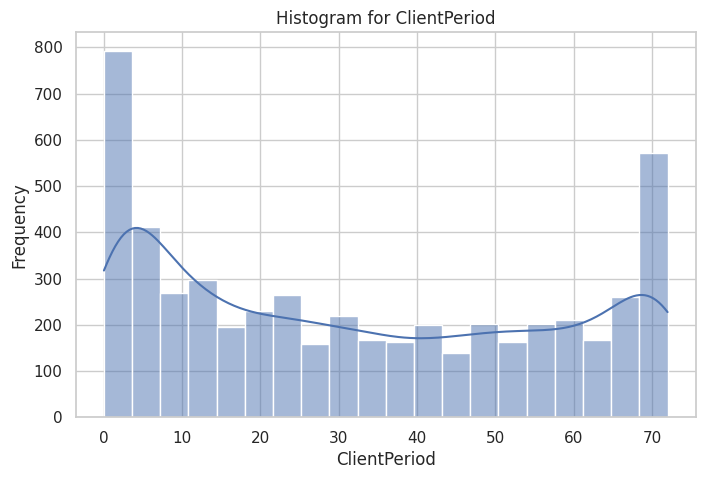

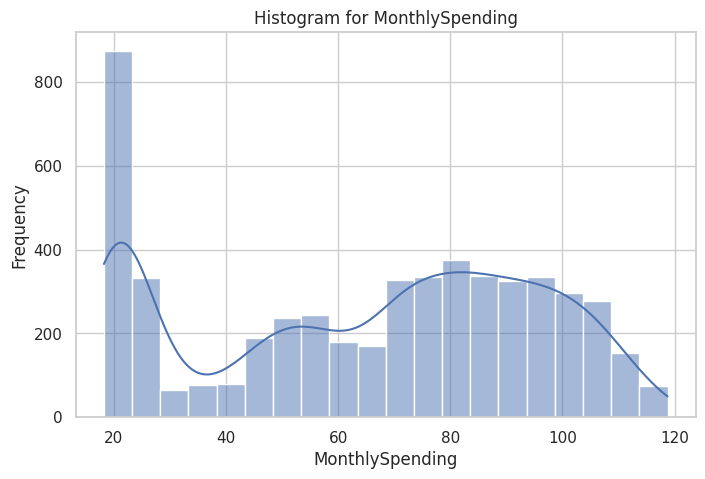

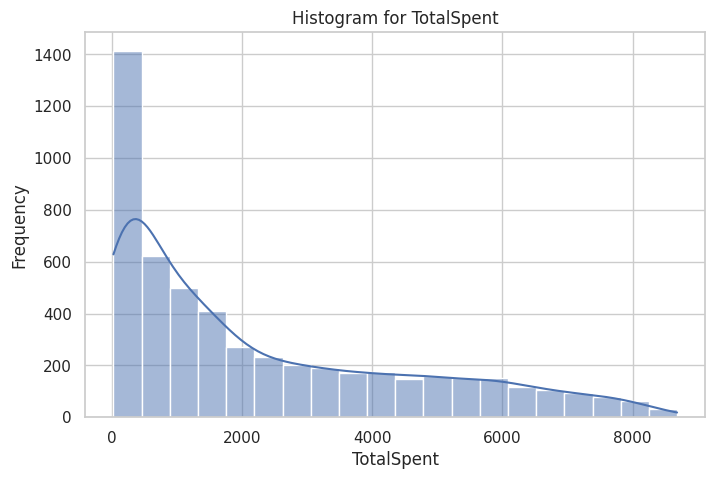

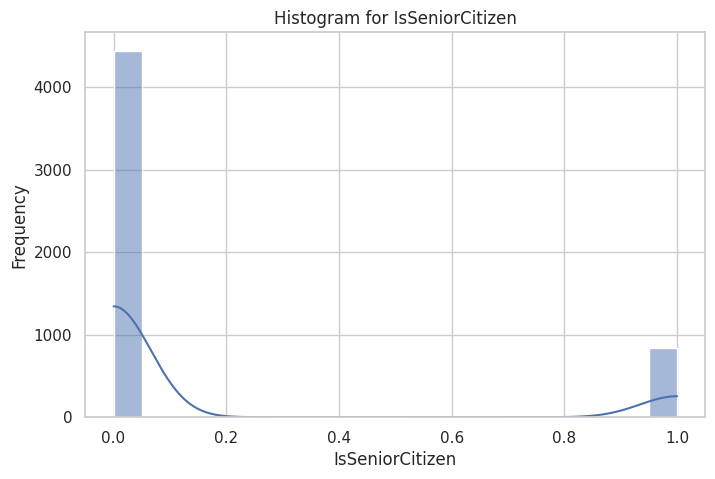

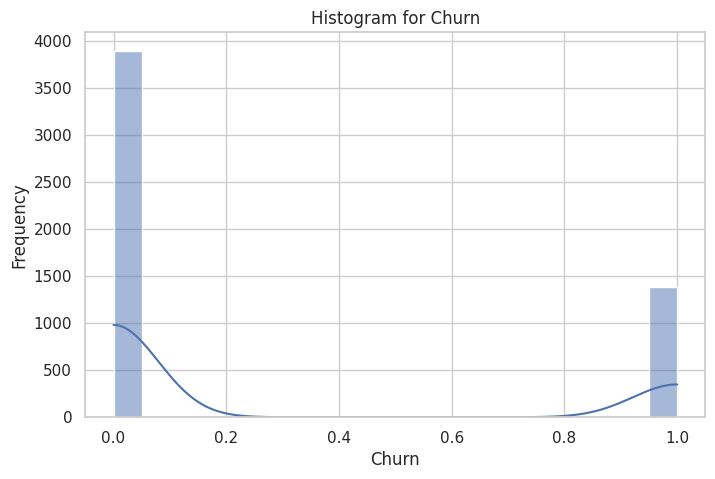

In [19]:
# Построение гистограмм для численных признаков
for col in numeric_features.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=numeric_features, x=col, bins=20, kde=True)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

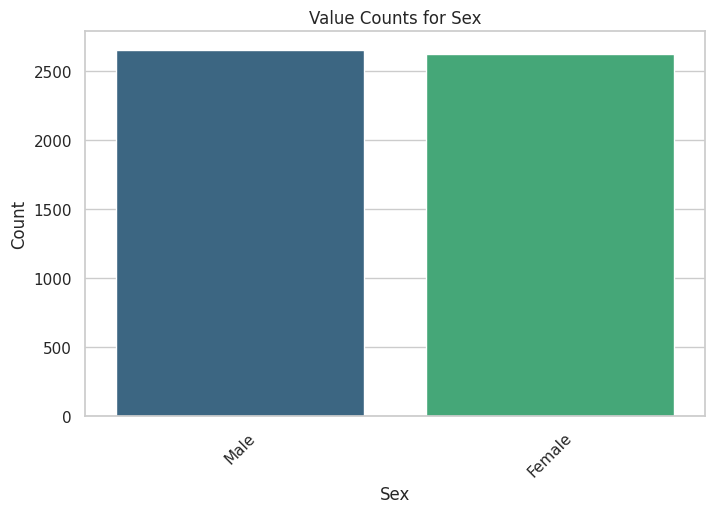

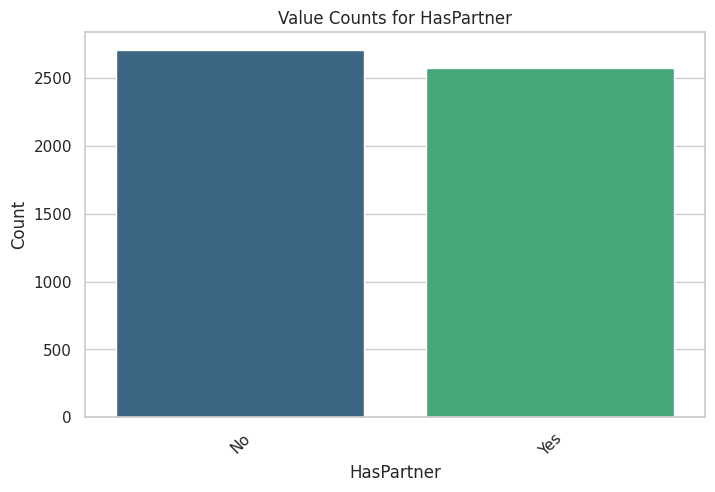

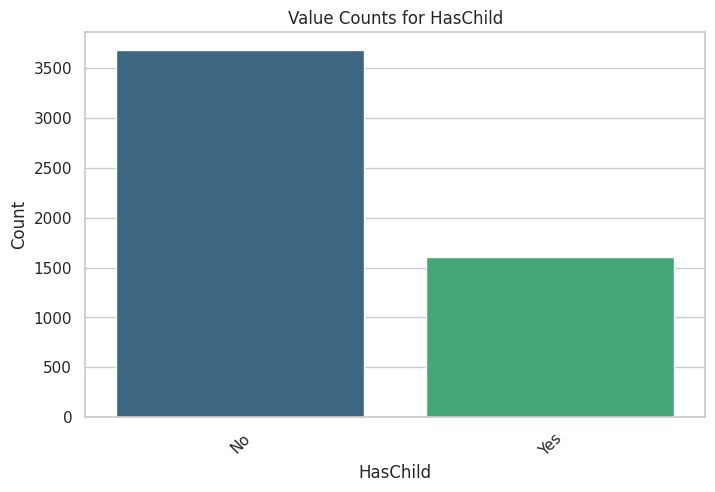

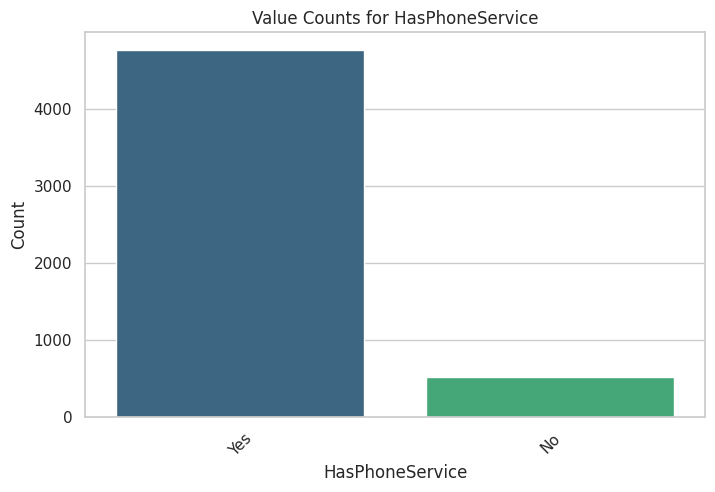

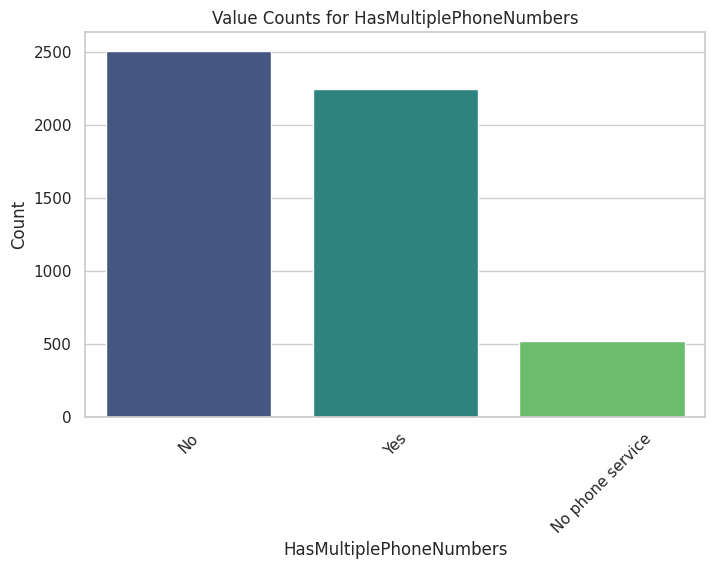

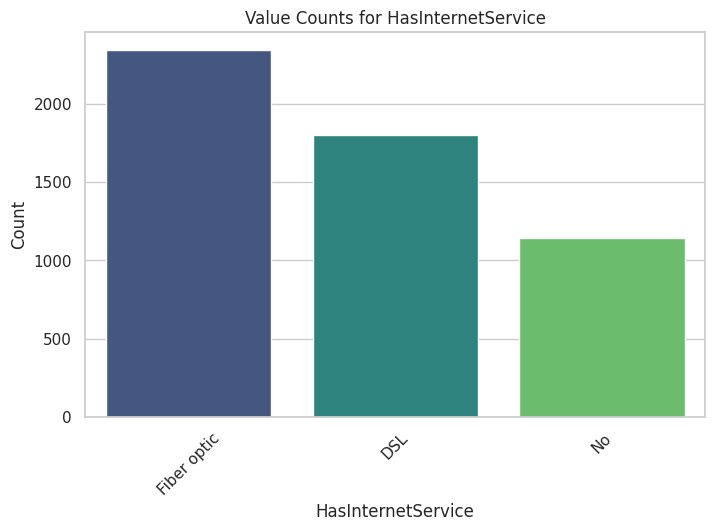

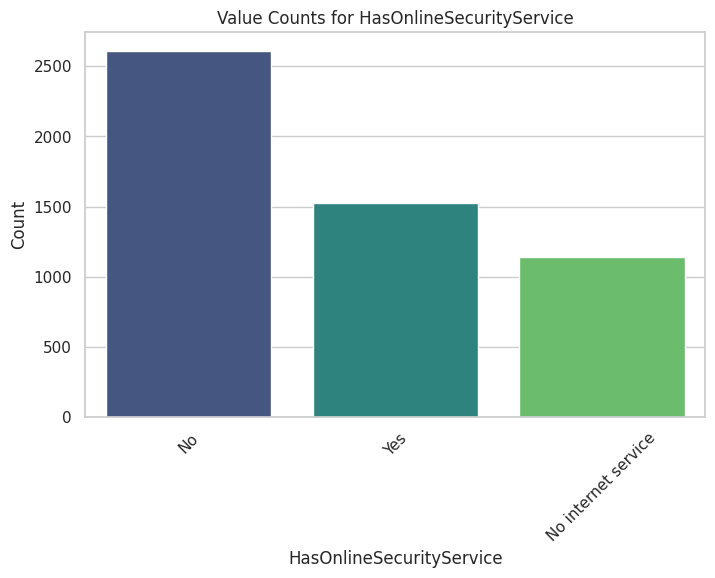

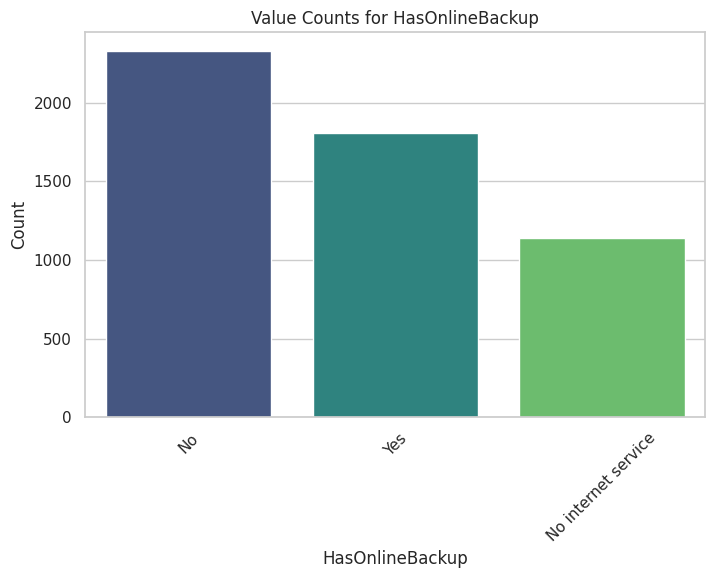

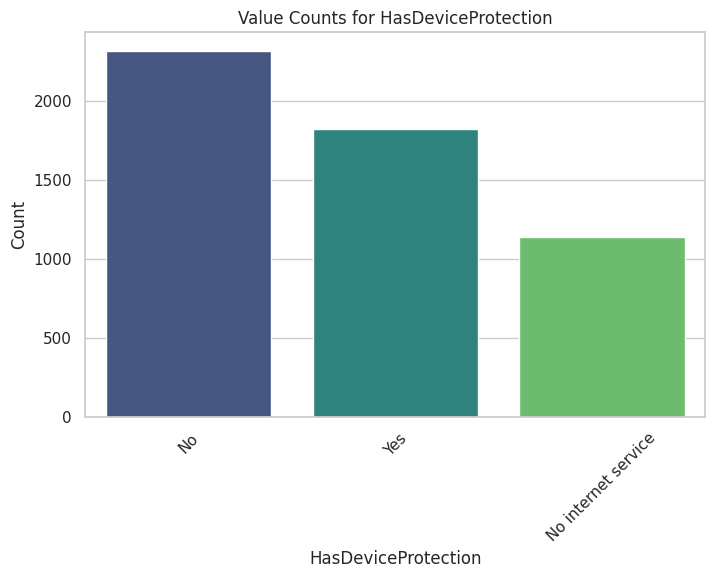

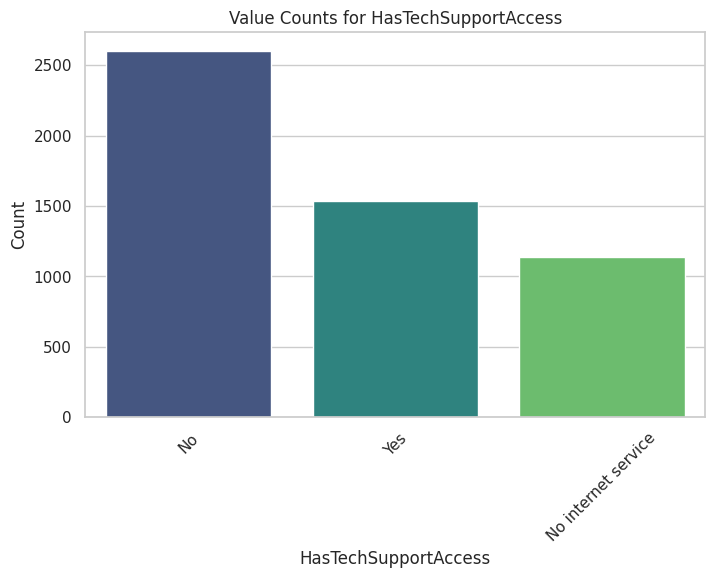

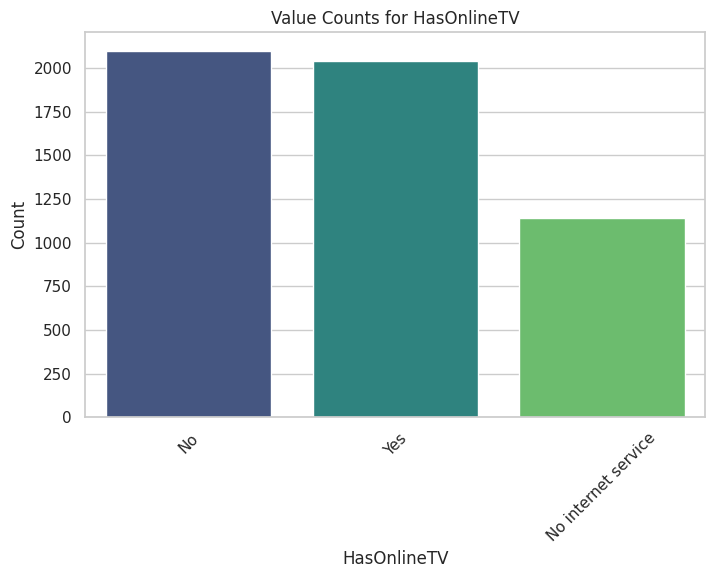

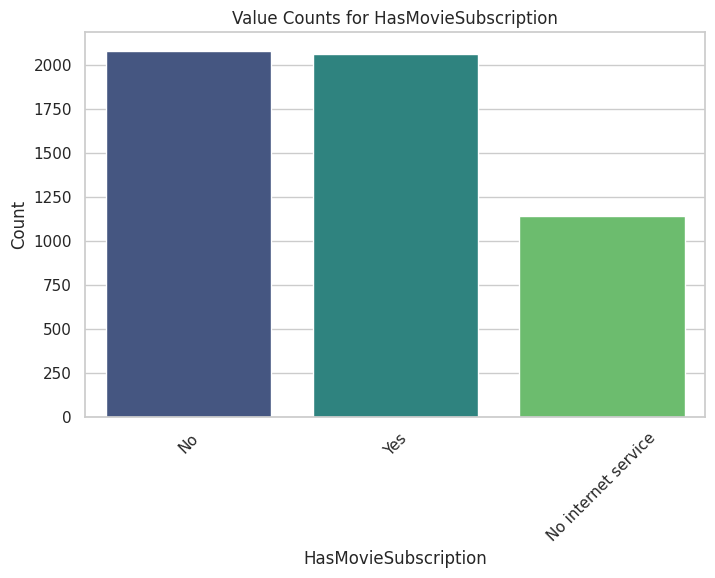

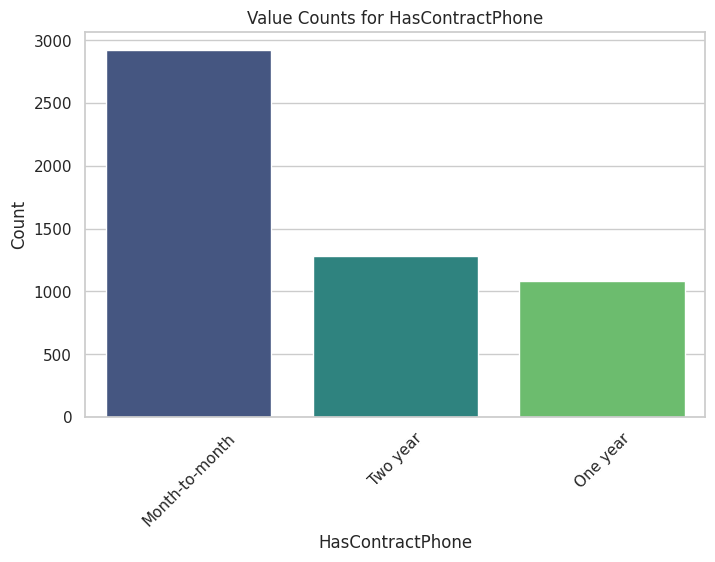

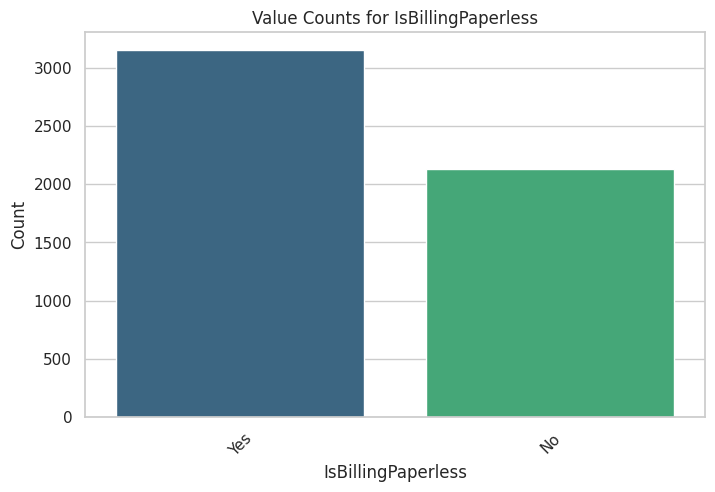

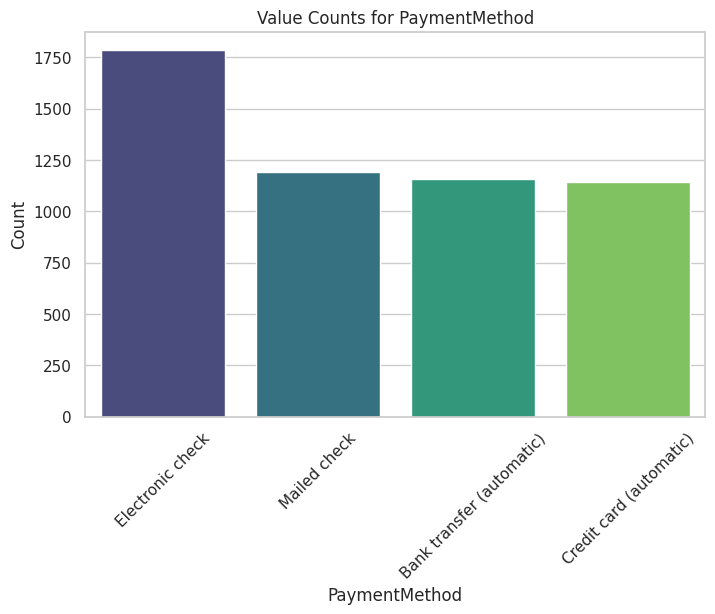

In [20]:
# Подсчет количества значений и построение bar диаграмм для категориальных признаков
for col in categorical_features.columns:
    plt.figure(figsize=(8, 5))
    value_counts = categorical_features[col].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts, palette="viridis")
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

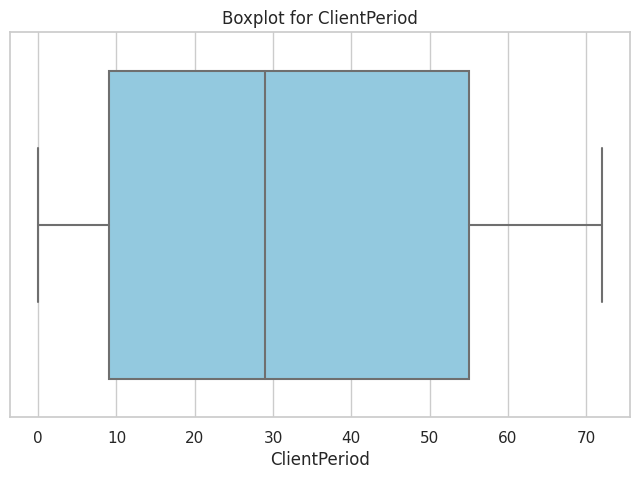

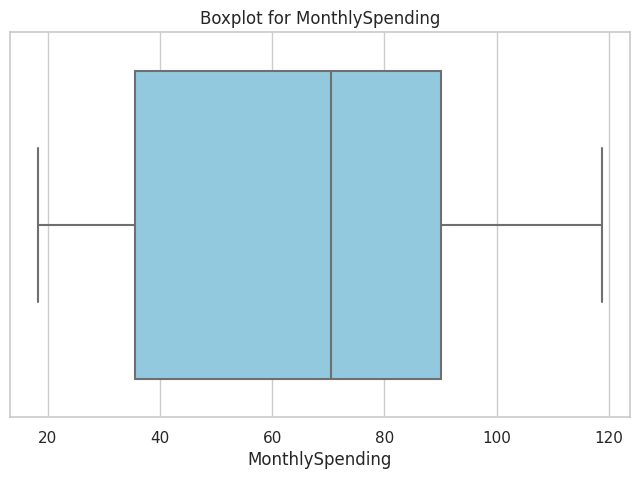

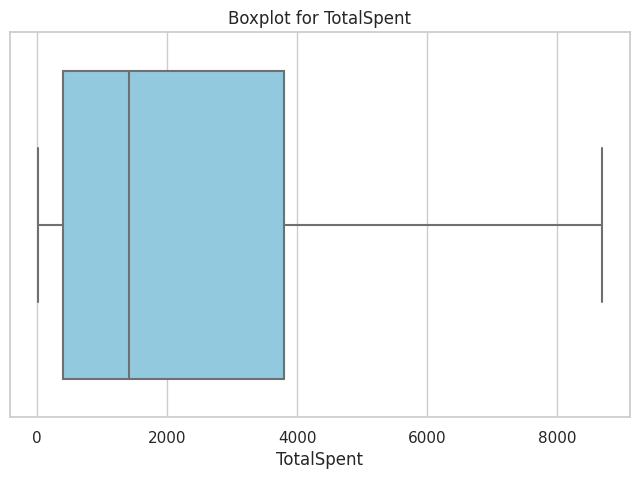

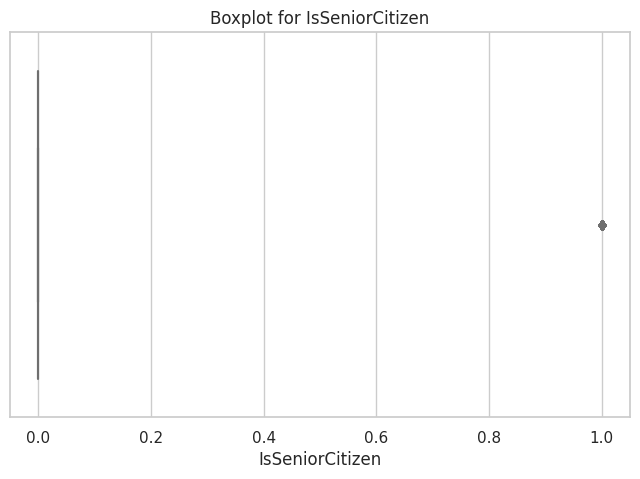

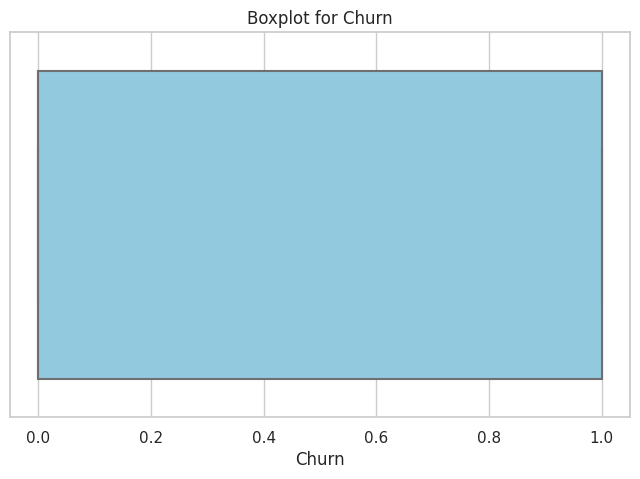

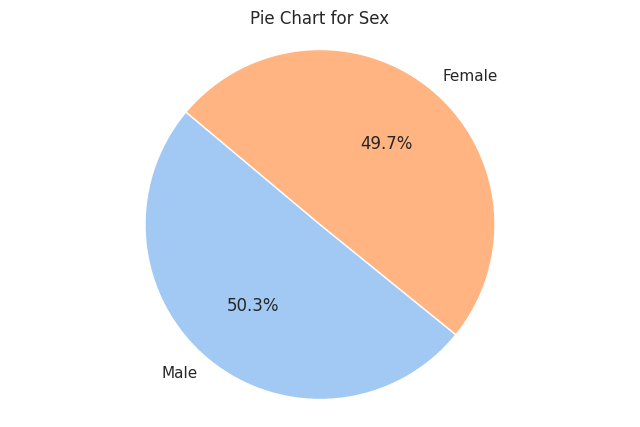

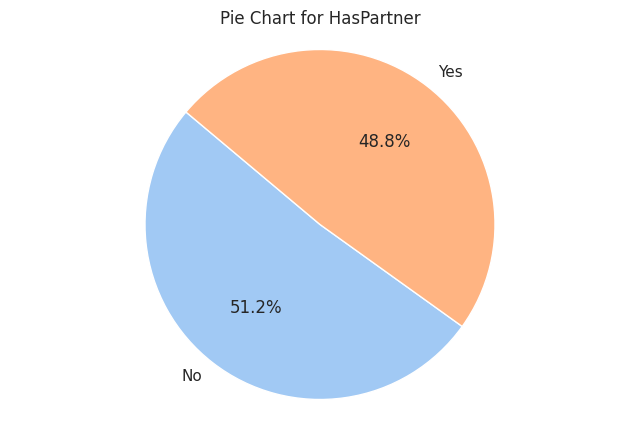

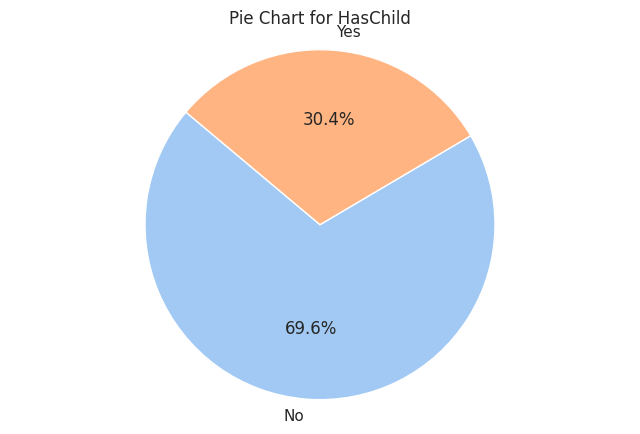

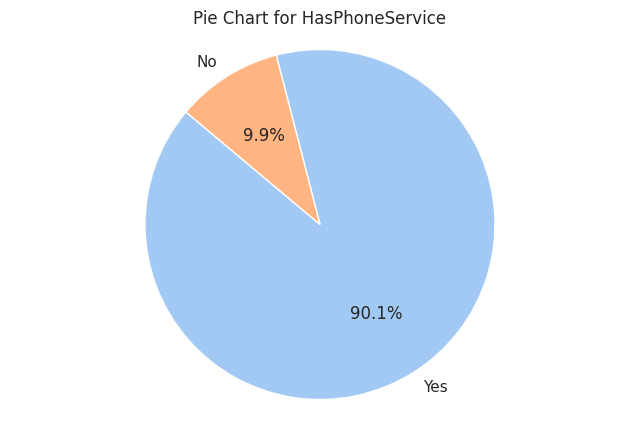

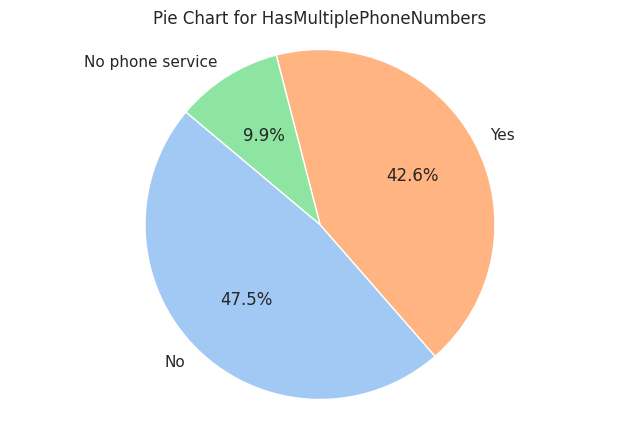

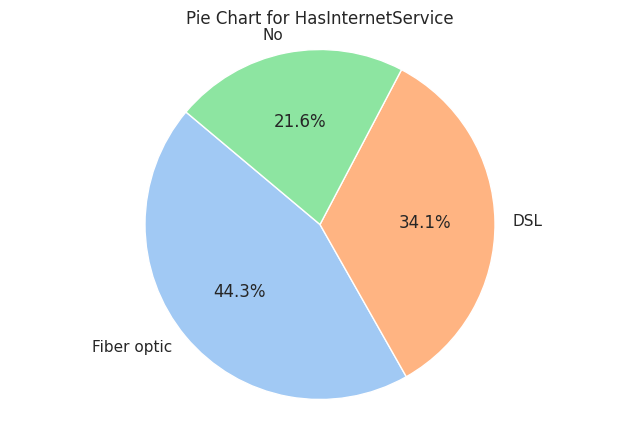

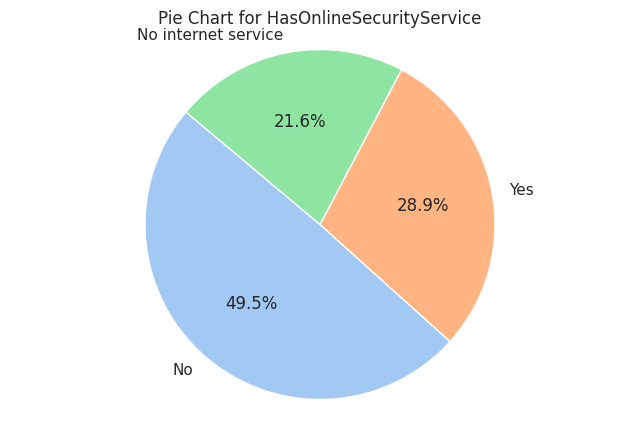

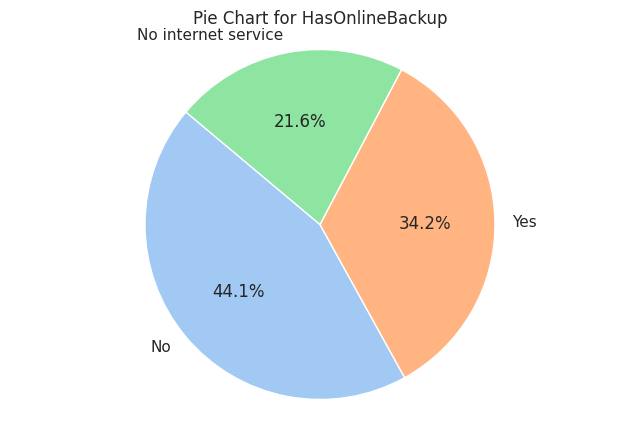

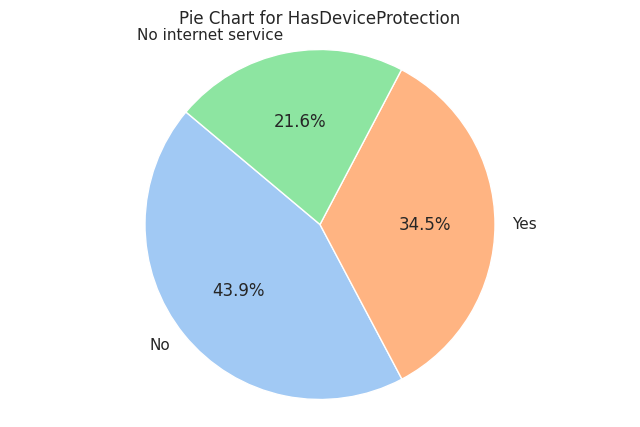

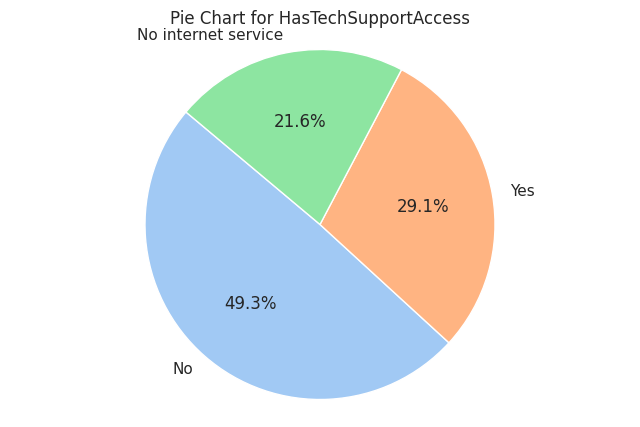

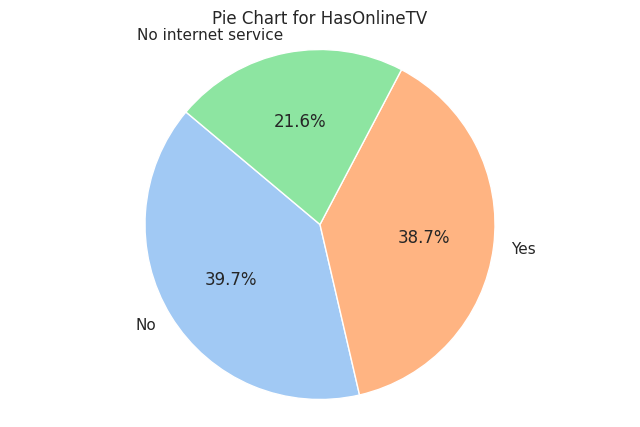

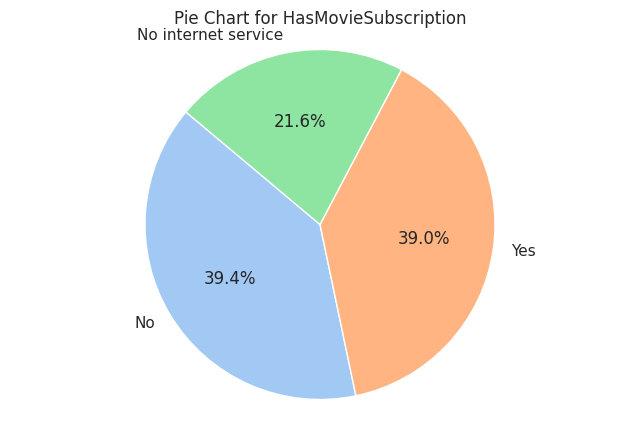

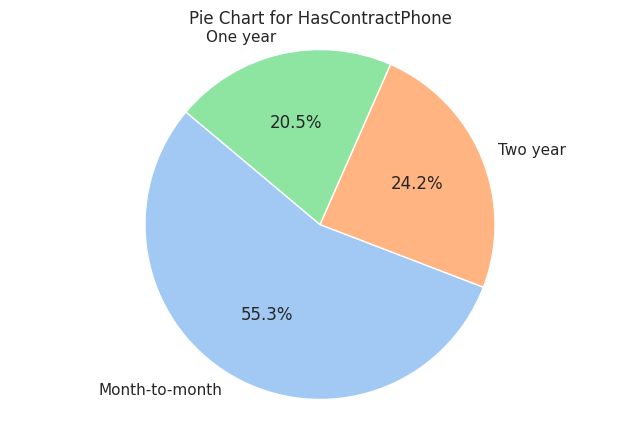

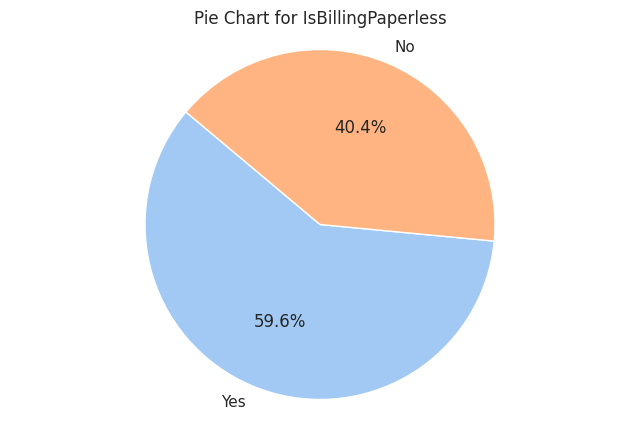

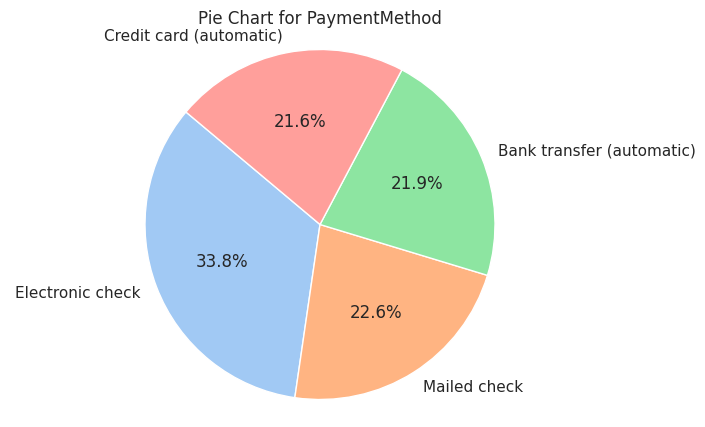

In [21]:
# Построение boxplot для численных признаков
for col in numeric_features.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=numeric_features, x=col, color='skyblue')
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.show()

# Подсчет количества значений и построение pie chart для категориальных признаков
for col in categorical_features.columns:
    plt.figure(figsize=(8, 5))
    value_counts = categorical_features[col].value_counts()
    colors = sns.color_palette('pastel')[0:len(value_counts)]
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f'Pie Chart for {col}')
    plt.axis('equal')
    plt.show()

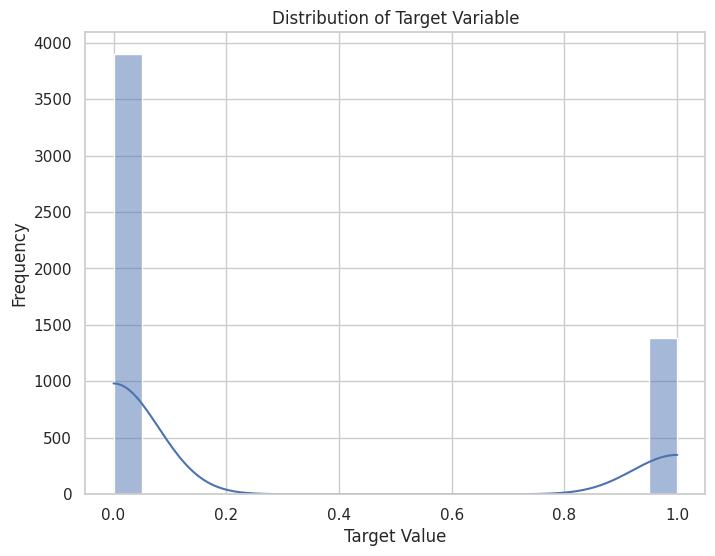

In [22]:
target_values = data['Churn']

plt.figure(figsize=(8, 6))
sns.histplot(target_values, bins=20, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()

In [57]:
data[data.Churn == 0].shape[0] / data[data.Churn == 1].shape[0] # несбалансированные (0 класса в 3 раза больше 1)

2.816473988439306

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [23]:
X = data.drop('Churn', axis=1)
y = data.Churn

In [25]:
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [27]:
# Преобразователи для числовых и категориальных признаков
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False)

In [28]:
# Объединение преобразователей с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [29]:
logreg = LogisticRegression()

In [30]:
pipeline = make_pipeline(preprocessor, logreg)

In [44]:
param_grid = {
    'logisticregression__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga', 'sag']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', refit=True)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(sparse=False),
                                                                         Index(['Sex', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'Ha...
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'],
      dtype='object'))])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [1000, 100, 10, 1, 0.1, 0.01,
                                                   0.001],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga',
                                                        'sag']},
             scoring='roc_auc')

In [47]:
# Лучшие параметры и соответствующий ROC-AUC
best_C = grid_search.best_params_
best_roc_auc = grid_search.best_score_
print(f"Лучшие параметры: {best_C}")
print(f"Лучший ROC-AUC: {best_roc_auc}")

Лучшие параметры: {'logisticregression__C': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Лучший ROC-AUC: 0.8450610588624281


In [46]:
y_pred = grid_search.predict(X_valid)
roc_auc_valid = roc_auc_score(y_valid, y_pred)
print(f"ROC-AUC на проверочном наборе данных: {roc_auc_valid}")

ROC-AUC на проверочном наборе данных: 0.7237272054059057


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию.

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [48]:
cat_features = list(categorical_features)

In [49]:
param_grid = {'iterations': [100, 500, 1000, 1500],
              'depth': [2, 4, 6, 8],
              'learning_rate': [0.001, 0.01, 0.06, 0.1]}

In [51]:
clf = CatBoostClassifier(cat_features=cat_features, random_seed=42)

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=roc_auc_scorer)
grid_search.fit(X, y)

best_params = grid_search.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
500:	learn: 0.1183334	total: 10.5s	remaining: 20.9s
501:	learn: 0.1181356	total: 10.5s	remaining: 20.9s
502:	learn: 0.1178120	total: 10.5s	remaining: 20.8s
503:	learn: 0.1175584	total: 10.5s	remaining: 20.8s
504:	learn: 0.1175353	total: 10.6s	remaining: 20.8s
505:	learn: 0.1171889	total: 10.6s	remaining: 20.8s
506:	learn: 0.1171225	total: 10.6s	remaining: 20.8s
507:	learn: 0.1166959	total: 10.6s	remaining: 20.7s
508:	learn: 0.1165530	total: 10.6s	remaining: 20.7s
509:	learn: 0.1161277	total: 10.7s	remaining: 20.7s
510:	learn: 0.1158386	total: 10.7s	remaining: 20.7s
511:	learn: 0.1156149	total: 10.7s	remaining: 20.6s
512:	learn: 0.1151568	total: 10.7s	remaining: 20.6s
513:	learn: 0.1147830	total: 10.7s	remaining: 20.6s
514:	learn: 0.1146107	total: 10.8s	remaining: 20.6s
515:	learn: 0.1144779	total: 10.8s	remaining: 20.6s
516:	learn: 0.1143132	total: 10.8s	remaining: 20.5s
517:	learn: 0.1141177	total: 10.8s	remaining: 20

In [61]:
best_model = CatBoostClassifier(**best_params, eval_metric='AUC', cat_features=cat_features, random_seed=42)

best_model.fit(X_train, y_train)

0:	total: 4.26ms	remaining: 4.26s
1:	total: 8.22ms	remaining: 4.1s
2:	total: 11ms	remaining: 3.65s
3:	total: 15.6ms	remaining: 3.89s
4:	total: 20.1ms	remaining: 4s
5:	total: 25.5ms	remaining: 4.23s
6:	total: 29.8ms	remaining: 4.23s
7:	total: 34.2ms	remaining: 4.24s
8:	total: 37.9ms	remaining: 4.17s
9:	total: 41.6ms	remaining: 4.12s
10:	total: 46.1ms	remaining: 4.14s
11:	total: 49.9ms	remaining: 4.11s
12:	total: 53.4ms	remaining: 4.05s
13:	total: 56.9ms	remaining: 4.01s
14:	total: 60.4ms	remaining: 3.96s
15:	total: 63.6ms	remaining: 3.91s
16:	total: 67.8ms	remaining: 3.92s
17:	total: 71.4ms	remaining: 3.9s
18:	total: 75.9ms	remaining: 3.92s
19:	total: 79.8ms	remaining: 3.91s
20:	total: 83.5ms	remaining: 3.89s
21:	total: 87ms	remaining: 3.87s
22:	total: 90.4ms	remaining: 3.84s
23:	total: 93.7ms	remaining: 3.81s
24:	total: 97.2ms	remaining: 3.79s
25:	total: 101ms	remaining: 3.79s
26:	total: 105ms	remaining: 3.77s
27:	total: 108ms	remaining: 3.75s
28:	total: 111ms	remaining: 3.73s
29:	tota

In [62]:
prediction = best_model.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, prediction)

print(f'ROC-AUC: {roc_auc:.5f}')

ROC-AUC: 0.85691


In [52]:
best_params

{'depth': 2, 'iterations': 1000, 'learning_rate': 0.01}

ROC-AUC: 0.85691, со следующими параметрами: {'depth': 2, 'iterations': 1000, 'learning_rate': 0.01}

# Предсказания

# ROC-AUC на Kaggle: 0.84996

In [64]:
prediction = best_model.predict_proba(X_test)[:, 1]

In [65]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = prediction
submission.to_csv('./my_submission.csv', index=False)
files.download('my_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

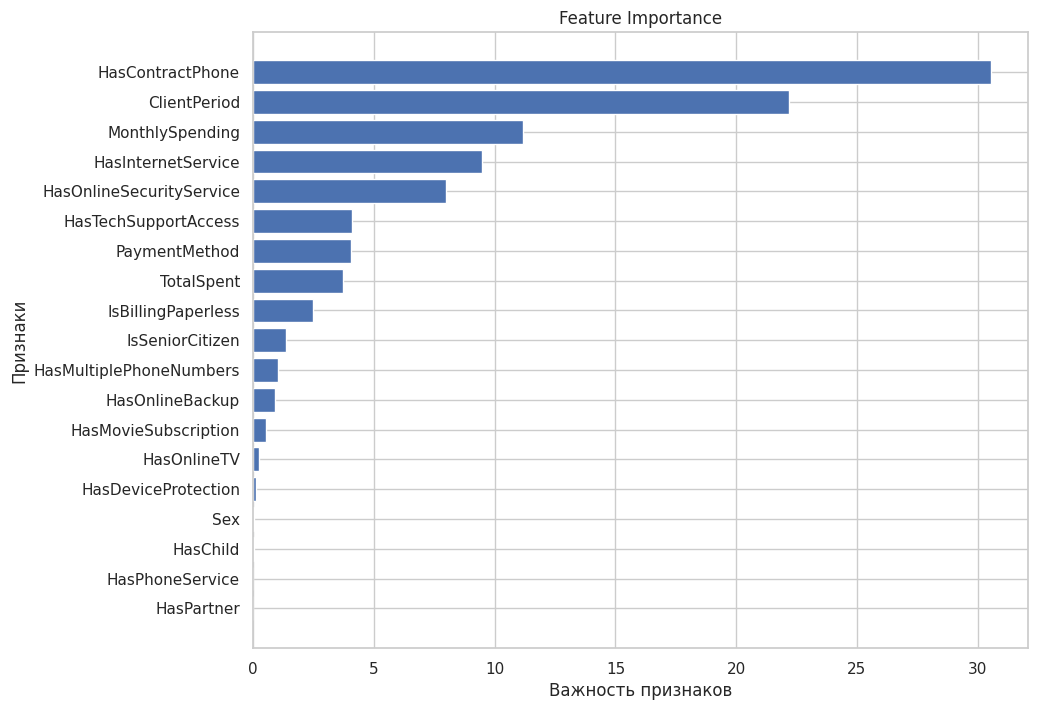

In [56]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Feature Importance')
plt.show()